In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import feature_column
from sklearn.model_selection import train_test_split

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [7]:
# Load the dataset
df = pd.read_csv('https://storage.googleapis.com/applied-dl/heart.csv')
print(df.shape)
df.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [8]:
# create train, val and test subsets
(train,test) = train_test_split(df,test_size=0.2)
(train,val) = train_test_split(train,test_size=0.2)
print(len(train),len(val),len(test))

193 49 61


In [41]:
# Convert the dataframes into datasets
def convert_df_to_ds(df,shuffle=True,batch_size=32):
    df = df.copy()
    labels = df.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(df),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(df))
    ds = ds.batch(batch_size)
    return ds
trainDS = convert_df_to_ds(train)
valDS = convert_df_to_ds(val)
testDS = convert_df_to_ds(test)

In [42]:
# Use this utility method to see the effect of feature_columns
def display_feature(ds,feature):
    rows = next(iter(ds))[0]
    fl = keras.layers.DenseFeatures(feature)
    print(fl(rows).numpy())

# display_feature(trainDS,feature_column.numeric_column('trestbps'))
# display_feature(trainDS,feature_column.bucketized_column(
#                     feature_column.numeric_column('age'),
#                     boundaries=[18,25,30,35,40,45,50,55,60,65,70,75]))
# display_feature(trainDS,feature_column.indicator_column(
#                 feature_column.categorical_column_with_vocabulary_list(
#                 'thal',['fixed','normal','reversible'])))

In [43]:
# Create feature list
features = []
for col in ['age','trestbps','chol','thalach','oldpeak','slope','ca']:
    features.append(feature_column.numeric_column(col))
features.append(feature_column.indicator_column(
                feature_column.categorical_column_with_identity('sex',
                num_buckets=2)))
features.append(feature_column.indicator_column(
                feature_column.categorical_column_with_identity('cp',
                num_buckets=5)))
features.append(feature_column.indicator_column(
                feature_column.categorical_column_with_identity('fbs',
                num_buckets=2)))
features.append(feature_column.indicator_column(
                feature_column.categorical_column_with_identity('restecg',
                num_buckets=3)))
features.append(feature_column.indicator_column(
                feature_column.categorical_column_with_identity('exang',
                num_buckets=2)))
features.append(feature_column.indicator_column(
                feature_column.categorical_column_with_vocabulary_list(
                    'thal',['fixed','normal','reversible'])))

In [44]:
def build_model():
    model = keras.Sequential([
        keras.layers.DenseFeatures(features),
        keras.layers.Dense(100,activation='relu'),
        keras.layers.Dense(100,activation='relu'),
        keras.layers.Dense(1,activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [53]:
model = build_model()

In [54]:
history = model.fit(trainDS,validation_data=valDS,epochs=50)

Epoch 1/50
7/7 [==============================] - 1s 78ms/step - loss: 4.9907 - accuracy: 0.3989 - val_loss: 3.0808 - val_accuracy: 0.7551
Epoch 2/50
7/7 [==============================] - 0s 25ms/step - loss: 3.9925 - accuracy: 0.7432 - val_loss: 2.4564 - val_accuracy: 0.7551
Epoch 3/50
7/7 [==============================] - 0s 26ms/step - loss: 1.7134 - accuracy: 0.6864 - val_loss: 0.6545 - val_accuracy: 0.7551
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 2.4561 - accuracy: 0.7393 - val_loss: 0.8340 - val_accuracy: 0.7755
Epoch 5/50
7/7 [==============================] - 0s 26ms/step - loss: 0.8315 - accuracy: 0.7221 - val_loss: 0.4989 - val_accuracy: 0.8571
Epoch 6/50
7/7 [==============================] - 0s 26ms/step - loss: 1.0847 - accuracy: 0.7154 - val_loss: 1.0311 - val_accuracy: 0.5714
Epoch 7/50
7/7 [==============================] - 0s 26ms/step - loss: 0.9382 - accuracy: 0.5817 - val_loss: 0.4314 - val_accuracy: 0.8571
Epoch 8/50
7/7 [===========

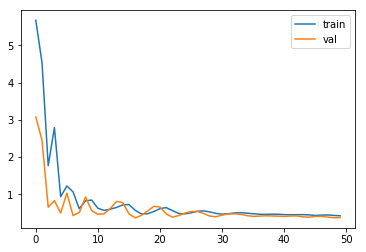

In [55]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.legend()
plt.show()

In [56]:
loss,accuracy = model.evaluate(testDS)
print(accuracy)

2/2 [==============================] - 0s 15ms/step - loss: 0.6200 - accuracy: 0.7541
0.75409836
